# Random Walk With Me

Random walks are a very handy simulation tool.
They can be used to simulate financial data (e.g. stock prices), count data as a function of time - even molecular motion.
They can also be used to traverse graphs.
This post explains the basics of the random walk in a couple of different scenarios (with pictures!) and shows some tips for implementing them in really nice ways.
The language of choice here is Julia, but the implementation details apply to any language with a decent random number generator and a `reduce` function.

To run this notebook, you'll need the [Gadfly](http://gadflyjl.org/) package and the [Distributions](http://distributionsjl.readthedocs.org/en/latest/index.html) package.
Install them as follows:

```julia
Pkg.add("Gadfly");
Pkg.add("Distributions");
```

In [1]:
using Gadfly        # Plots!
using Distributions # Random Numbers!

## The Math

Now that we've exhausted ourselves with all that code, let's do some math.
The textbook (and by textbook I mean Wikipedia) definition of a random walk is 

> A random walk is a mathematical formalization of a path that consists of a succession of random steps.
>
> \- Wikipedia

So what that means is that each _step_ of the path is random.
That's pretty general.
For this discussion we're going to limit ourselves to random walks whose steps depend only on the current step's value.
These random walks can be described as [Markov Chains](http://en.wikipedia.org/wiki/Markov_chain).
Specifically, that means that each step in our random walk is a function of the current step, so 

$s_{n+1} = f(x_n)$, 

where $f$ is some function and $x_n$ is the current value of the walk.

But remember we're talking about _random_ walks, so really $f(x_n)$ is some kind of random variable, or - more generally - a function of some distribution,

$s_{n+1} = f(x_n) \sim D(\theta(x_n))$.

Here, $D$ is a distribution and $\theta$ is the parameters for that distribution.
Now Markov Chain random walks can be applied to a variety of spaces - we'll focus on discrete (such as count data) and continuous (such as stock prices) spaces here, but you can also random walk on lattices and graphs where each node has only a few available paths.
This is one way to compute [PageRank](http://en.wikipedia.org/wiki/PageRank#Distributed_Algorithm_for_PageRank_Computation).

Note that the Markov Chain constraint I conveniently set for myself limits the function _and_ distribution parameter parameters (?) to only the latest value of the walk, but to make things simpler I'll declare that the distribution and the step doesn't depend on the current position, meaning

$s_{n+1} = f \sim D(\theta)$.

Having the size of the step depend on the current position is a really useful formalism, particularly in the physical sciences (where you might have some force/field term acting on the walker in addition to the random elements), but the implementation without this dependence is really _really_ simple.

So, at each step, we can compute the position of the next step with the following equation

$x_{n+1} = x_n + f^{D(\theta)}$

where $f$ is a function of a random draw from a distribution $D(\theta)$.

## The Code

There are a few ways to implement this.
The simplest way is to use loops, like so:

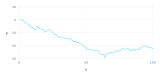

In [2]:
# Initialize the array to fill.
gaussian_walk = zeros(100);

# Initialize the starting position.
gaussian_walk[1] = 1.0;

# Loop over the walk and add the random noise.
for ii=2:length(gaussian_walk)
    gaussian_walk[ii] = gaussian_walk[ii-1] + rand(Normal());
end

draw(SVG(16cm, 8cm), 
     plot(x=1:length(gaussian_walk), 
          y=gaussian_walk, Geom.line))

So that's three distinct statements to produce the walk.
Can we do it in one?
Thanks to `reduce`, we most certainly can.
If you're unfamiliar with how `reduce` works, yours truly is a little obsessed and wrote a post about it [here](http://timothyrenner.github.io/programming/2015/04/04/reduce-for-the-uninitiated.html).

Let's try to duplicate the loop method with `reduce`.
It's a little more concise, but all around isn't that different.

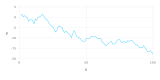

In [3]:
gaussian_walk_reduced = 
    reduce((a,x) -> [a (a[end] + rand(Normal()))], # Add a random normal to the last accumulator value.
    [1.0],                                         # Starting position.
    1:99);                                         # Number of iterations.

draw(SVG(16cm, 8cm), 
     plot(x=1:length(gaussian_walk_reduced), 
          y=gaussian_walk_reduced, Geom.line))

The `1:99` is a little annoying - it serves to index the collection for iteration, and that's it.
Fewer indices is nice, but there's a better way.

Well, remember when we said the random draws would be independent from the position?
This means we can perform the random draws _ahead_ of time and zip along the step changes.

In [4]:
gaussian_walk_reduced_two = 
    reduce((a,x) -> [a (a[end] + x)], # Grab the last element and add x (the random draw)
    [1.0],                            # Starting accumulator
    [rand(Normal(), 99)]);            # This is the collection of deltas

draw(SVG(16cm, 8cm), 
     plot(x=1:length(gaussian_walk_reduced_two), 
          y=gaussian_walk_reduced_two, Geom.line))

LoadError: DimensionMismatch("vectors must have same lengths")

Okay, we're almost there, but we need one more piece to the puzzle.
Remember our equation for the random walk?

$ x_{n+1} = x_n + f^{D(\theta)}$

Well that little $f$ up there isn't going to apply itself.
There are two places to do it - we can apply it in the accumulator, or we can apply it on the collection of steps we're reducing.
It seems more natural to apply the function to the collection itself, so that's what I'll do.

Suppose we only wanted a Gaussian random walk that goes in the positive direction - then $f$ is `abs`.

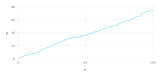

In [5]:
gaussian_walk_positive = 
    reduce((a,x) -> [a (a[end] + x)], # Same walker reduce function.
    [1.0],                            # Starting point.
    abs(rand(Normal(), 99)));         # Absolute value of the Normal draws.

draw(SVG(16cm, 8cm), 
     plot(x=1:length(gaussian_walk_positive), 
          y=gaussian_walk_positive, Geom.line))

Note how nice it was to take advantage of Julia's vectorized array operations.

One more scenario that adds an additional twist.
Suppose we want to model count data as a function of time and, for reasons related to the process, the count data carries some "memory."
That is, there are trends in the counts due to the underlying data set (for example, number of tweets during the Oscars).
We can coarsely model this with an integer random walk, but there are a couple of caveats:

* Counts can't go below zero.
* Trends can go down.

We can deal with trends going down by drawing from random integers between, say, -3 and 3.
The counts below zero is where things get dicey because that condition actually _does_ depend on the position.
Luckily, it's an easy one - we just modify our reducer to be slightly aware of the value.

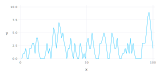

In [6]:
count_walk =
reduce((a,x) -> [a max(0, a[end] + x)],
[0],
rand(DiscreteUniform(-3,3), 99));

draw(SVG(16cm, 8cm), 
     plot(x=1:length(count_walk), 
          y=count_walk, Geom.line))

Let's get really generic with this.
Our "recipe" is as follows:

- A starting point.
- The length of the walk.
- A distribution for the random elements.
- A transformation to apply to the random elements.
- A function to apply to the new value in the reducer (function of current position).

In [7]:
function randomWalkReduce(
    start::Number,                 # Starting point.
    walkLength::Integer,           # Length of the walk.
    distribution::Distribution,    # Distribution to draw from.
    stepTransformation::Function,  # Transformation applied to each step.
    valueTransformation::Function) # Transformation applied to each value.
    
    return reduce(
        (a,x) -> [a valueTransformation(a[end] + x)],
        [start],
        map(stepTransformation, rand(distribution, walkLength - 1)));
end;

Now our counting example looks like the following:

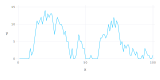

In [8]:
srand(0) # For future comparison with an alternate implementation.
count_walk_two = randomWalkReduce(0, 100, DiscreteUniform(-3, 3), identity, x -> max(0, x))

draw(SVG(16cm, 8cm), plot(x=1:length(count_walk_two), y=count_walk_two, Geom.line))

Here's what it looks like with the loops.

In [9]:
function randomWalkLoop(start::Number, 
                        walkLength::Integer, 
                        distribution::Distribution,
                        stepTransformation::Function,
                        valueTransformation::Function)
    
    walk = [start; zeros(walkLength - 1)]
    
    for ii=2:length(walk)
        walk[ii] = valueTransformation(
            walk[ii-1] + 
            stepTransformation(rand(distribution)))
    end
    
    return walk
end;                 

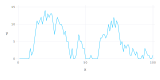

In [10]:
srand(0)
count_walk_three = randomWalkLoop(0, 100, DiscreteUniform(-3, 3), identity, x -> max(0, x));

draw(SVG(16cm, 8cm), plot(x=1:length(count_walk_three), y=count_walk_three, Geom.line))

There is some question as to whether there's a difference in runtime between the two.
After all, the loop version preallocates the values.
If you're running this, it will take a while. 
I'll let you guess how much faster one is than the other.

In [11]:
@time randomWalkReduce(0, int64(1e5), DiscreteUniform(-3, 3), identity, x -> max(0, x));
@time randomWalkLoop(  0, int64(1e5), DiscreteUniform(-3, 3), identity, x -> max(0, x));

LoadError: UndefVarError: int64 not defined

All of those extra allocations and gc time really _really_ killed the reduce version.
That said, I don't think the development of `randomWalkReduce` was a waste of time.
After all, it was trivially obvious to figure out the generic set of arguments and transformations needed, as well as where to put them.
From there `randomWalkLoop` was pretty straightforward, and is just as flexible.
I'm not confident that starting with the loop would have gotten me to the solution in a reasonably logical way.

Moral of the story: maybe start with the simplest solution, but don't be afraid to loop it out for speed once it's locked down.